In [1]:
path = 'resources/Language Detection.csv'

In [2]:
import string 
import re
import codecs
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import tensorflow as tf
import keras
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import joblib
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv(path)
df

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English
...,...,...
10332,ನಿಮ್ಮ ತಪ್ಪು ಏನು ಬಂದಿದೆಯೆಂದರೆ ಆ ದಿನದಿಂದ ನಿಮಗೆ ಒ...,Kannada
10333,ನಾರ್ಸಿಸಾ ತಾನು ಮೊದಲಿಗೆ ಹೆಣಗಾಡುತ್ತಿದ್ದ ಮಾರ್ಗಗಳನ್...,Kannada
10334,ಹೇಗೆ ' ನಾರ್ಸಿಸಿಸಮ್ ಈಗ ಮರಿಯನ್ ಅವರಿಗೆ ಸಂಭವಿಸಿದ ಎ...,Kannada
10335,ಅವಳು ಈಗ ಹೆಚ್ಚು ಚಿನ್ನದ ಬ್ರೆಡ್ ಬಯಸುವುದಿಲ್ಲ ಎಂದು ...,Kannada


In [4]:
X = df.iloc[:,0]
y = df.iloc[:,1]
print(np.unique(y))

le = LabelEncoder()
y = le.fit_transform(y)

['Arabic' 'Danish' 'Dutch' 'English' 'French' 'German' 'Greek' 'Hindi'
 'Italian' 'Kannada' 'Malayalam' 'Portugeese' 'Russian' 'Spanish'
 'Sweedish' 'Tamil' 'Turkish']


<AxesSubplot:xlabel='Language', ylabel='count'>

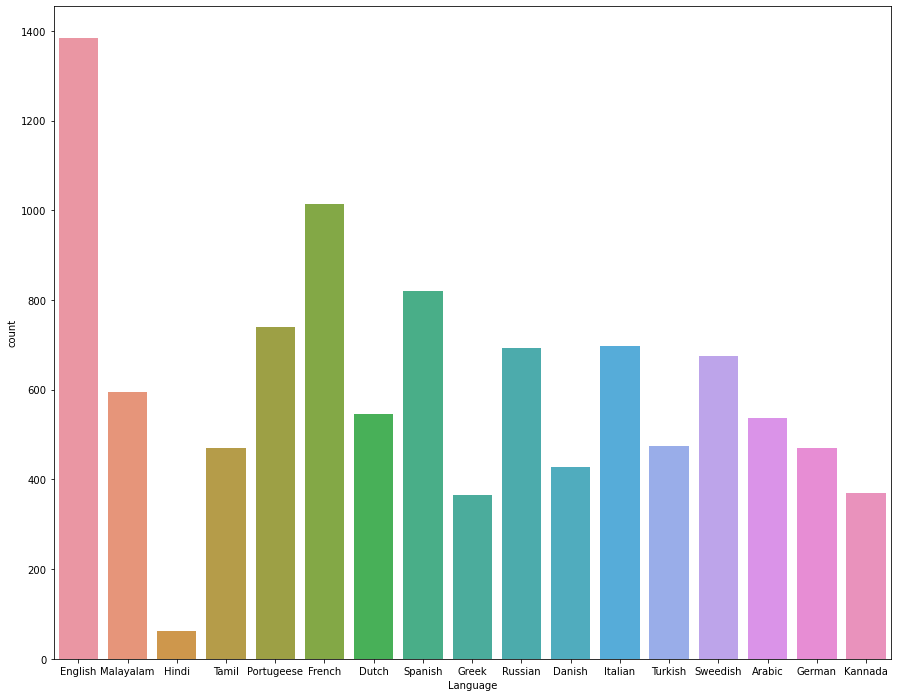

In [5]:
plt.figure(figsize=(15,12))
sns.countplot(x = df['Language'], data=df)

In [6]:
data_list = []
for text in X:
    text = re.sub(r'[!@#$(),"%^*?:;~`0-9]', ' ', text)
    text = re.sub(r'[[][  ]]', ' ', text)
    text = text.lower()
    data_list.append(text)
data_list[0]

' nature  in the broadest sense  is the natural  physical  material world or universe.'

In [85]:
x_train, x_test, y_train, y_test = train_test_split(data_list, y, test_size = 0.20)

DIFFERENT VECTORIZATION TECHNIQUES

Glove

In [87]:
import numpy as np
path2 = 'resources/glove.6B.50d.txt'
embeddings_dict={}
with open(path2,'rb') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [11]:
sents = [sent.split() for sent in x_train]
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_NUM_WORDS = 100
MAX_SEQUENCE_LENGTH = 20
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(sents)
sequences = tokenizer.texts_to_sequences(sents)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

from keras.layers import Embedding
from keras.initializers import Constant

EMBEDDING_DIM = embeddings_dict.get(b'a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix_Glove = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_dict.get(word.encode("utf-8")) 
    if embedding_vector is not None:
        embedding_matrix_Glove[i] = embedding_vector

Skip-Gram

In [17]:
from gensim import models
w2v = models.KeyedVectors.load_word2vec_format(
'resources/GoogleNews-vectors-negative300.bin', binary=True)

In [18]:
sents = [sent.split() for sent in x_train]
custom_model = models.Word2Vec(sents, min_count=1,workers=4)

In [25]:
custom_model.train(x_train, total_examples=1, epochs=1)

(531270, 1026421)

TF-IDF

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
tfidf = TfidfVectorizer(stop_words='english', analyzer=lambda x: x)
logistic = LogisticRegression(solver='liblinear', multi_class='auto')

tfidf_logistic = Pipeline([
    ('tfidf', tfidf), 
    ('logistic', logistic)
])

In [14]:
from scipy.stats import randint, uniform

w2v_params = {'w2v__size': [100, 150, 200]}
tfidf_params = {'tfidf__ngram_range': [(1, 1), (1, 2)]}
logistic_params = {'logistic__C': [0.5, 1.0, 1.5]}
xgb_params = {'xgb__max_depth': randint(low=3, high=12),
              'xgb__colsample_bytree': uniform(loc=0.8, scale=0.2),
              'xgb__subsample': uniform(loc=0.8, scale=0.2)}

tfidf_logistic_params = {**tfidf_params, **logistic_params}
w2v_xgb_params = {**w2v_params, **xgb_params}

In [15]:
from sklearn.model_selection import RandomizedSearchCV

cv = 3
n_iter = 3
random_state = 1234
scoring = 'accuracy'

all_models = [
    ('tfidf_logistic', tfidf_logistic, tfidf_logistic_params)
]

all_models_info = []
for name, model, params in all_models:
    print('training:', name)
    model_tuned = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        cv=cv,
        n_iter=n_iter,
        n_jobs=-1,
        verbose=1,
        scoring=scoring,
        random_state=random_state,
        return_train_score=False
    ).fit(x_train, y_train)
    
    y_test_pred = model_tuned.predict(x_test)
    test_score = accuracy_score(y_test, y_test_pred)
    info = name, model_tuned.best_score_, test_score, model_tuned
    all_models_info.append(info)

columns = ['model_name', 'train_score', 'test_score', 'estimator']
results = pd.DataFrame(all_models_info, columns=columns)
results = (results
           .sort_values('test_score', ascending=False)
           .reset_index(drop=True))
results

training: tfidf_logistic
Fitting 3 folds for each of 3 candidates, totalling 9 fits


,model_name,train_score,test_score,estimator
0,tfidf_logistic,0.915951,0.916828,"RandomizedSearchCV(cv=3,\n e..."


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
tfidf = TfidfVectorizer(ngram_range=(3,5),analyzer='char')

In [ ]:
sents1 = x_train
sents2 = x_test
transformed1 = tfidf.fit_transform(sents1)
transformed2 = tfidf.transform(sents2)

Count Vectorizer

In [ ]:
sents = x_train

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_count_train = cv.fit_transform(sents)
X_count_test = cv.transform(x_test)

LATER SHIT

In [10]:
text_clf = pipeline.Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])


print(text_clf.get_params().keys())
text_clf.fit(x_train, y_train)

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__alpha', 'clf__class_prior', 'clf__fit_prior'])


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [11]:
print(classification_report(y_test, text_clf.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       110
           1       0.99      0.90      0.94        84
           2       0.99      0.97      0.98        96
           3       0.83      1.00      0.91       278
           4       0.97      0.99      0.98       202
           5       1.00      0.98      0.99       101
           6       1.00      0.94      0.97        72
           7       1.00      0.62      0.77        16
           8       0.99      0.96      0.98       142
           9       1.00      0.97      0.98        63
          10       1.00      0.98      0.99       133
          11       0.99      0.99      0.99       143
          12       1.00      0.97      0.98       127
          13       0.98      0.99      0.99       166
          14       0.97      0.99      0.98       137
          15       1.00      0.99      1.00       111
          16       1.00      0.77      0.87        87

    accuracy              

In [12]:
accuracy_score(y_test, text_clf.predict(x_test))

0.9647001934235977

In [27]:
cv = CountVectorizer()
X_new = cv.fit_transform(data_list).toarray()
joblib.dump(cv, "resources/cv.pkl")

['resources/cv.pkl']

In [170]:
x_train, x_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.20)

In [125]:
model1 = MultinomialNB()
model1.fit(x_train, y_train)
y_pred = model1.predict(x_test)
ac1 = accuracy_score(y_test, y_pred)
print(ac1)

0.9753384912959381


In [19]:
model2 = GaussianNB()
model2.fit(x_train, y_train)
y_pred = model2.predict(x_test)
ac2 = accuracy_score(y_test, y_pred)
print(ac2)

0.9796905222437138


## implimenting NN

In [195]:
#one hot encode the target variable
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
dummy_y = tf.keras.utils.to_categorical(encoded_Y)
dummy_y.shape

(10337, 17)

In [116]:
encoded_Y = encoded_Y.astype(np.float32)

In [121]:
# X_train = x_train.values
# X_test = x_test.values
X_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
X_test = dummy_y.reshape(dummy_y.shape[0], dummy_y.shape[1], 1)

In [196]:
#Implement neural network using tensorflow
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=128, activation='tanh'))
ann.add(tf.keras.layers.Dense(units=256, activation='tanh'))
ann.add(tf.keras.layers.Dense(units=128, activation='tanh'))
ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
#ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann.add(tf.keras.layers.Dropout(0.2))
ann.add(tf.keras.layers.Dense(units = 17, activation='softmax'))


In [113]:
encoded_Y

array([ 3.,  3.,  1., ...,  8., 11.,  1.], dtype=float32)

In [197]:
ann.compile(optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
ann.fit(X_new,encoded_Y, epochs=10, batch_size=32)
ann.save('resources/language_predictor.h5')

Epoch 1/10
324/324 [==============================] - 8s 22ms/step - loss: 0.4371 - accuracy: 0.8926
Epoch 2/10
324/324 [==============================] - 7s 21ms/step - loss: 0.0342 - accuracy: 0.9919
Epoch 3/10
324/324 [==============================] - 7s 20ms/step - loss: 0.0158 - accuracy: 0.9968
Epoch 4/10
324/324 [==============================] - 7s 20ms/step - loss: 0.0120 - accuracy: 0.9969
Epoch 5/10
324/324 [==============================] - 7s 20ms/step - loss: 0.0093 - accuracy: 0.9975
Epoch 6/10
324/324 [==============================] - 7s 21ms/step - loss: 0.0100 - accuracy: 0.9971
Epoch 7/10
324/324 [==============================] - 7s 21ms/step - loss: 0.0119 - accuracy: 0.9966
Epoch 8/10
324/324 [==============================] - 7s 20ms/step - loss: 0.0084 - accuracy: 0.9975
Epoch 9/10
324/324 [==============================] - 7s 20ms/step - loss: 0.0099 - accuracy: 0.9968
Epoch 10/10
324/324 [==============================] - 7s 21ms/step - loss: 0.0088 - accura

In [192]:
dummy_y_test = tf.keras.utils.to_categorical(encoder.transform(y_test))
print(accuracy_score(y_test, np.argmax(ann.predict(x_test), axis=1)))
print(f1_score(y_test, np.argmax(ann.predict(x_test), axis=1), average='macro'))

0.9622823984526112
0.9590643420165255


## nearest neighbours

In [36]:
x_train,x_val = train_test_split(x_train, test_size=0.2)
y_train,y_val = train_test_split(y_train, test_size=0.2)

In [30]:
def find_best_k(x_train, y_train, x_val, y_val):
    best_k = 0
    best_score = 0
    for k in range(1, 11):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)
        pred = knn.predict(x_val)
        score = f1_score(y_val, pred, average='macro')
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

In [31]:
find_best_k(x_train, y_train, x_val, y_val)

7

In [37]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print(accuracy_score(y_test, y_pred))


0.0672147001934236


In [ ]:
#concat train and val
x_train = np.concatenate((x_train, x_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

## Xgboost

In [20]:
clf = XGBClassifier(random_state = 0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

C:\Users\jahna\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:46:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [80]:
from keras.layers import Dropout, Dense,Input,Embedding,Flatten, MaxPooling1D, Conv1D
from keras.models import Sequential,Model
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import Concatenate

In [81]:
def loadData_Tokenizer(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train = text[0:len(X_train), ]
    X_test = text[len(X_train):, ]
    embeddings_index = {}
    f = open(path2, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_index))
    return (X_train, X_test, word_index,embeddings_index)

In [82]:
def Build_Model_CNN_Text(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
    """
        def buildModel_CNN(word_index, embeddings_index, nclasses, MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5):
        word_index in word index ,
        embeddings_index is embeddings index, look at data_helper.py
        nClasses is number of classes,
        MAX_SEQUENCE_LENGTH is maximum lenght of text sequences,
        EMBEDDING_DIM is an int value for dimention of word embedding look at data_helper.py
    """
    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) !=len(embedding_vector):
                print("could not broadcast input array from shape",str(len(embedding_matrix[i])),
                                 "into shape",str(len(embedding_vector))," Please make sure your"
                                 " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True)
    # applying a more complex convolutional approach
    convs = []
    filter_sizes = []
    layer = 5
    print("Filter  ",layer)
    for fl in range(0,layer):
        filter_sizes.append((fl+2))
    node = 128
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    for fsz in filter_sizes:
        l_conv = Conv1D(node, kernel_size=fsz, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(5)(l_conv)
        #l_pool = Dropout(0.25)(l_pool)
        convs.append(l_pool)
    l_merge = Concatenate(axis=1)(convs)
    l_cov1 = Conv1D(node, 5, activation='relu')(l_merge)
    l_cov1 = Dropout(dropout)(l_cov1)
    l_pool1 = MaxPooling1D(5)(l_cov1)
    l_cov2 = Conv1D(node, 5, activation='relu')(l_pool1)
    l_cov2 = Dropout(dropout)(l_cov2)
    l_pool2 = MaxPooling1D(30)(l_cov2)
    l_flat = Flatten()(l_pool2)
    l_dense = Dense(1024, activation='relu')(l_flat)
    l_dense = Dropout(dropout)(l_dense)
    l_dense = Dense(512, activation='relu')(l_dense)
    l_dense = Dropout(dropout)(l_dense)
    preds = Dense(nclasses, activation='softmax')(l_dense)
    model = Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model